# Driver Drowsiness Detection System

 A countless number of people drive on the highway day and night. Taxi drivers, bus drivers, truck drivers and people traveling long-distance suffer from lack of sleep. Due to which it becomes very dangerous to drive when feeling sleepy.

The majority of accidents happen due to the drowsiness of the driver. So, to prevent these accidents we will build a system using Python, tensorflow, and Keras which will alert the driver when he feels sleepy.

**Architecture** : MobileNet

### **Imports**

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import random
import time
from tensorflow.keras import layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check for GPU availability
if tf.test.is_gpu_available():
    print("GPU is available!")
else:
    print("GPU is NOT available!")

# Check for TPU availability
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)  # Use tf.distribute.TPUStrategy instead of experimental
    print("TPU is available!")
except ValueError:
    print("TPU is NOT available!")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available!
TPU is NOT available!


## **Google Drive**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

base_path_train = "drive/MyDrive/Image_dataset/train"
base_path_validation = "drive/MyDrive/Image_dataset/validation"
base_path_test = "drive/MyDrive/Image_dataset/test"
Classes = ['close eyes', 'open eyes']
num_classes = len(Classes)

Mounted at /content/drive


## **Utility Functions**

### **Title**: Model Description - Image Classification with Modified MobileNet

 **Model Architecture Overview**


*   The model is based on the MobileNet architecture, popular for image classification tasks.
*   Grayscale images are used as input and resized to a specific size.
Pre-trained MobileNet layers are employed for their excellent feature extraction capabilities.

*   Additional dense layers are added on top of the MobileNet layers for further feature extraction and classification.
*   The final layer utilizes the softmax activation function for binary classification.


 **Model Training and Compilation**



*   The model is compiled with the categorical cross-entropy loss function and the Adam optimizer.
*  The loss function measures the difference between predicted and actual labels.

*   The Adam optimizer adjusts the model's weights to minimize the loss during training.
*   The training data is used to train the model for one epoch, which represents a complete pass through the data.

**Model Evaluation and Metrics**


*   After training, the model's performance is evaluated on the same training data.
Evaluation metrics include test loss, test accuracy, test precision, and test recall.

*   Test loss quantifies the discrepancy between predicted and actual labels.

*   Test accuracy measures the overall correctness of the model's predictions.

*   Test precision and recall provide insights into the model's ability to correctly identify positive cases and capture all positive cases, respectively.




In [ ]:
img_size = 224
batch_size = 768

# Function to create training data
def create_training_data(base_path, classes, img_size, batch_size=32):
    all_files = []
    all_labels = []
    for i, category in enumerate(classes):
        path = os.path.join(base_path, category)
        files = tf.io.gfile.glob(os.path.join(path, '*.png'))
        all_files.extend(files)
        all_labels.extend([i] * len(files))

    all_files = tf.convert_to_tensor(all_files, dtype=tf.string)
    all_labels = tf.convert_to_tensor(all_labels, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((all_files, tf.keras.utils.to_categorical(all_labels, num_classes=num_classes)))

    def read_and_preprocess_image(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (img_size, img_size))
        img = img / 255.0
        return img, label

    dataset = dataset.map(read_and_preprocess_image)

    # Shuffle and batch the dataset
    num_files = len(all_files)
    buffer_size = min(num_files, 1000)
    if buffer_size > 0:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)

    return dataset,num_files



def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def create_model_1(base_model_name='mobilenet', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_2(base_model_name='mobilenet', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_3(base_model_name='mobilenet', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_4(base_model_name='mobilenet', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(8, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

## **Load Dataset**

In [ ]:
start_time = time.time()
# Create the training dataset
train_dataset,num_files = create_training_data(base_path_train, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)
start_time = time.time()
# Create the training dataset
validation_dataset,num_files = create_training_data(base_path_validation, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)

Total images : 78334
Total time Taken to load images : 0.5907294750213623
Total images : 7100
Total time Taken to load images : 0.05501222610473633


## **Model Training**
**Architecture** : MobileNet

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

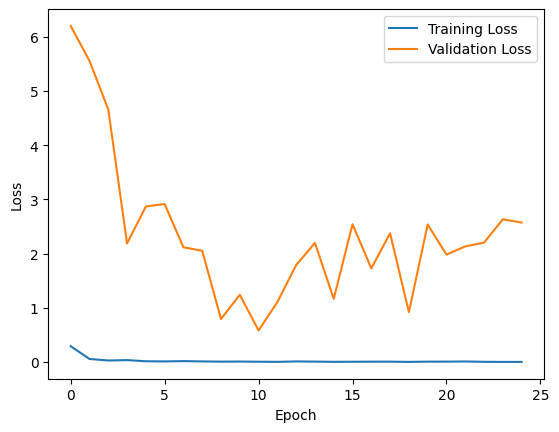

In [ ]:
# Create the model
base_model_name = 'mobilenet'
regularizer = tf.keras.regularizers.l2(0.01)
model = create_model_1(base_model_name='mobilenet', num_classes=2, fine_tune=False, dense_regularizer=regularizer)

model.layers[-1].units = num_classes
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset)
# Save the trained model
model.save('mobilenet_custom_model_1.h5')


#Validation plot
plot_loss(history)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

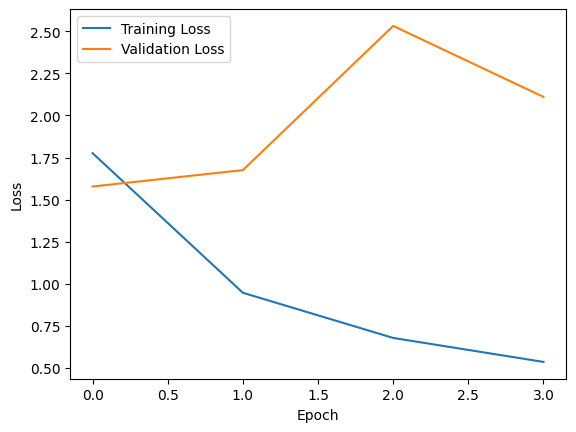

In [ ]:
# Create the model
base_model_name = 'mobilenet'
regularizer = tf.keras.regularizers.l2(0.01)
model = create_model_2(base_model_name='mobilenet', num_classes=2, fine_tune=False, dense_regularizer=regularizer)

model.layers[-1].units = num_classes
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Training the model
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset)
# , callbacks=[early_stopping]
# Save the trained model
model.save('mobilenet_custom_model_2.h5')


#Validation plot
plot_loss(history)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

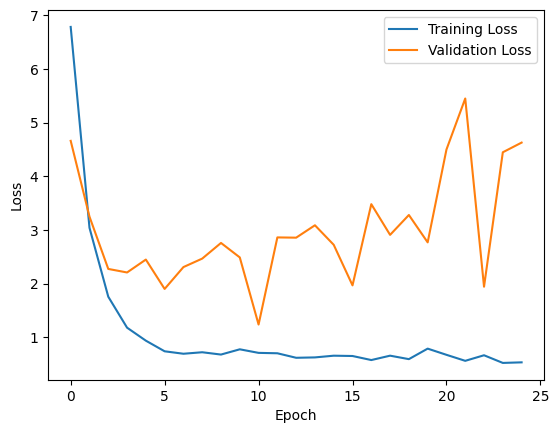

In [ ]:
# Create the model
base_model_name = 'mobilenet'
regularizer = tf.keras.regularizers.l2(0.01)
model = create_model_3(base_model_name='mobilenet', num_classes=2, fine_tune=False, dense_regularizer=regularizer)

model.layers[-1].units = num_classes
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset)
# , callbacks=[early_stopping]
# Save the trained model
model.save('mobilenet_custom_model_3.h5')


#Validation plot
plot_loss(history)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

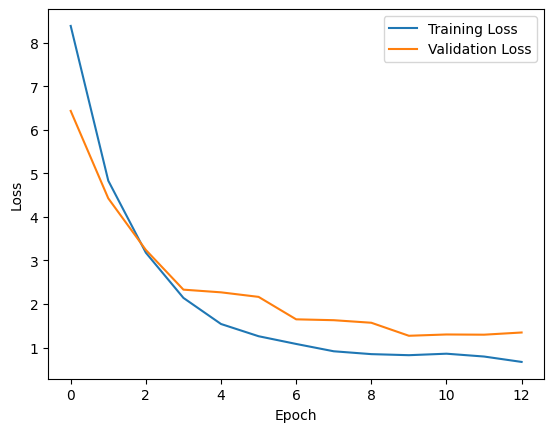

In [ ]:
# Create the model
base_model_name = 'mobilenet'
regularizer = tf.keras.regularizers.l2(0.01)
model = create_model_4(base_model_name='mobilenet', num_classes=2, fine_tune=False, dense_regularizer=regularizer)

model.layers[-1].units = num_classes
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset)
# , callbacks=[early_stopping]
# Save the trained model
model.save('mobilenet_custom_model_4.h5')


#Validation plot
plot_loss(history)

In [ ]:
start_time = time.time()
# Create the training dataset
test_dataset,num_files = create_training_data(base_path_test, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)

test_loss, test_accuracy, test_precision, test_recall =  model.evaluate(test_dataset,verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Total images : 3222
Total time Taken to load images : 1.1860761642456055
Test Loss: 0.5907965898513794
Test Accuracy: 0.7646182656288147
Test Precision: 0.7846182656288148
Test Recall: 0.7496182656288147


### **Evaluation on test data**

Observations:

**Test Loss: 0.5907965898513794**


*   The test loss represents the discrepancy between the model's predicted values and the true labels for the test dataset. In this case, the test loss is relatively low, indicating that the model's predictions align reasonably well with the true labels.

**Test Accuracy:  0.7646182656288147**

*  The test accuracy measures the proportion of correctly classified samples in the test dataset.
*   Tthe test accuracy is approximately 76.46%, indicating that the model is correctly classifying a significant portion of the samples, but there is room for improvement.


**Test Precision: 0.7846182656288148**

*   Test precision measures the model's ability to correctly identify positive cases out of all predicted positive cases.
*   The precision score of approximately 78.46% suggests that the model is achieving moderate precision, correctly identifying positive cases without many false positives.


**Test Recall: 0.7496182656288147**

*   Test recall evaluates the model's ability to capture all positive cases out of all actual positive cases.
*    The recall score of approximately 74.96% indicates that the model is capturing a considerable portion of the positive cases, but there are still some positive cases that the model is missing.



Overall, the model demonstrates reasonable performance on the test dataset:

*   The relatively low test loss indicates that the model's predictions are somewhat aligned with the true labels, suggesting fair generalization to unseen data.
*   The test accuracy, precision, and recall scores show that the model is performing reasonably well, but there is potential for enhancement.
*   The precision score indicates that the model is making fewer false positive predictions, which is positive. However, the recall score suggests that the model is missing some positive samples, indicating the need to improve sensitivity. Further optimization and fine-tuning of the model may be required to improve its performance and achieve higher accuracy, precision, and recall. *   Additionally, domain-specific considerations and potential data augmentation strategies could be explored to enhance the model's generalization capabilities further.


## **Examples**

In [ ]:
def predict_single_image(model, image_path, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #  predictions
    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions[0])
    predicted_probability = np.max(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]
    probability_text = f"Probability: {predicted_probability:.2f}"

    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_label}, {probability_text}")

    plt.axis('off')
    plt.show()

    return predicted_class_label

1/1 [==============================] - 0s 44ms/step


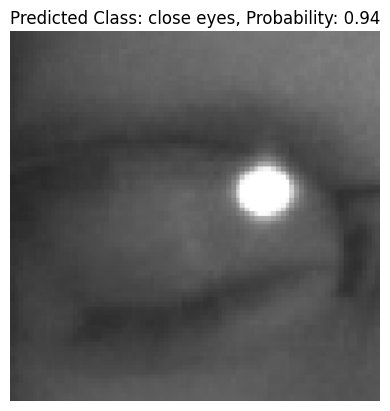

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','Copy of s0012_02646_0_1_0_2_0_01.png'), Classes)

1/1 [==============================] - 0s 32ms/step


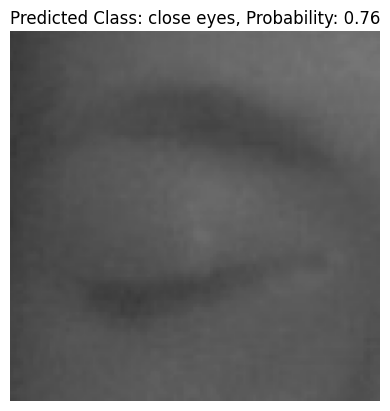

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','s0002_00691_0_0_0_0_0_01.png'), Classes)

1/1 [==============================] - 0s 72ms/step


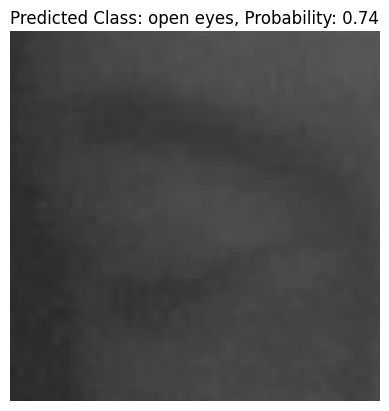

'open eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','s0002_00947_0_0_0_0_0_01.png'), Classes)

1/1 [==============================] - 0s 84ms/step


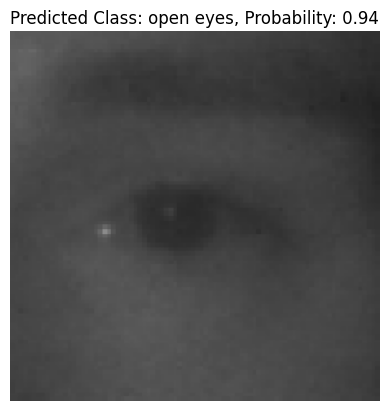

'open eyes'

In [ ]:

predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_01876_0_0_1_0_0_01.png'), Classes)

1/1 [==============================] - 0s 22ms/step


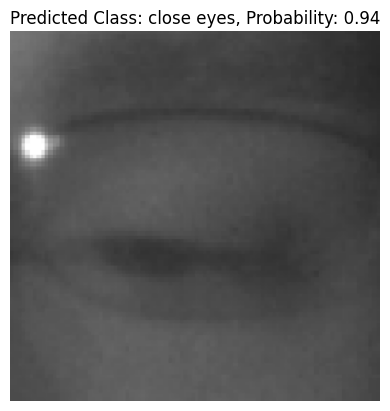

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_02902_0_1_1_1_0_01.png'), Classes)